### Grid Search

- Finding the values of the important parameters of a model (the ones that provide the best generalization performance) is a tricky task, but necessary for almost all models and datasets. 
- Because it is such a common task, there are standard methods in scikit-learn to help you with it. The most commonly used method is **grid search**, which basically means trying all possible combinations of the parameters of interest.

Consider the case of a kernel SVM with an RBF (radial basis function) kernel, as implemented in the SVC class. Here there are two important parameters: **the kernel bandwidth, gamma, and the regularization parameter, C**.
- Lets try the values 0.001, 0.01, 0.1, 1, 10, and 100 for the parameter C, and the same for gamma. 
- Since we have six different settings for C and gamma that we want to try, we have 36 combinations of parameters in total.

#### Simple Grid Search

In [11]:
import numpy as np
import pandas as pd
import mglearn

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [8]:
# naive grid search implementation
from sklearn.svm import SVC
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
print("Size of training set: {}   size of test set: {}".format(
      X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112   size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


**Dangers of Overfitting**

The accuracy given above may not be really good for the following reasons:
- We tried many different parameters but selected the one with best accuracy. But this accuracy may not carry over to new data.
- Because we used the test data to adjust the parameters, we can no longer use it to assess how good the model is.
- One way to resolve this problem is to split the data again, so we have three sets: the training set to build the model, the validation (or development) set to select the parameters of the model, and the test set to evaluate the performance of the selected parameters.
- After selecting the best parameters using the validation set, we can rebuild a model using the parameter settings we found, but now training on both the training data and the validation data. 
- This way, we can use as much data as possible to build our model. 

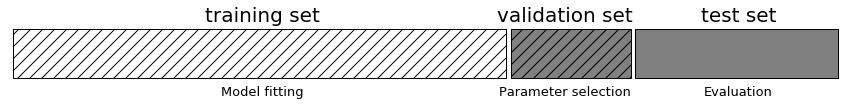

In [12]:
mglearn.plots.plot_threefold_split()

In [9]:
from sklearn.svm import SVC
# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
# split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


- The distinction between the training set, validation set, and test set is fundamentally important to applying machine learning methods in practice.
- It is important to keep a separate test set, which is only used for the final evaluation. 
- It is good practice to do all exploratory analysis and model selection using the combination of a training and a validation set, and reserve the test set for a final evaluation

#### Grid Search with Cross-Validation

While the method of splitting the data into a training, a validation, and a test set that we just saw is workable, and relatively commonly used, it is quite sensitive to how exactly the data is split.

For a better estimate of the generalization performance, instead of using a single split into a training and a validation set, we can use cross-validation to evaluate the performance of each parameter combination.

In [14]:
from sklearn.model_selection import cross_val_score

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters,
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

To evaluate the accuracy of the SVM using a particular setting of C and gamma using five-fold cross-validation, we need to train 36 * 5 = 180 models. As you can imagine, the main downside of the use of cross-validation is the time it takes to train all these models.

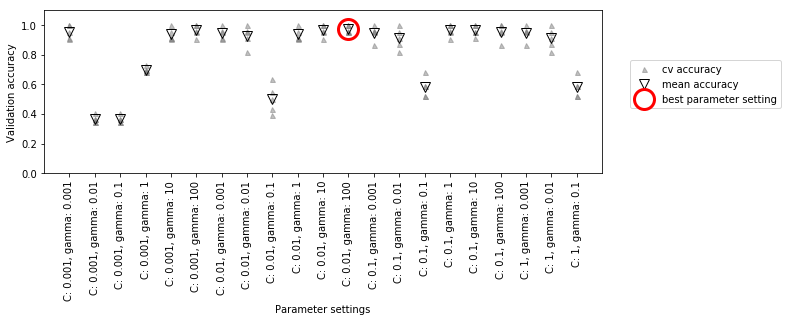

In [15]:
mglearn.plots.plot_cross_val_selection()

- Because grid search with cross-validation is such a commonly used method to adjust parameters, scikit-learn provides the GridSearchCV class, which implements it in the form of an estimator.
- To use the GridSearchCV class, you first need to specify the parameters you want to search over using a dictionary.
- GridSearchCV will then perform all the necessary model fits.

In [16]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


We can now instantiate the GridSearchCV class with the model (SVC), the parameter grid to search (param_grid), and the cross-validation strategy we want to use (say, five-fold stratified cross-validation)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

GridSearchCV will use cross-validation in place of the split into a training and validation set that we used before. However, we still need to split the data into a training and a test set, to avoid overfitting the parameters

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

The grid_search object that we created behaves just like a classifier; we can call the standard methods fit, predict, and score on it

In [20]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [21]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.97


In [22]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.1}
Best cross-validation score: 0.97


**Using the score method (or evaluating the output of the predict method) employs a model trained on the whole train‐
ing set. The best_score_ attribute stores the mean cross-validation accuracy, with cross-validation performed on the training set**

In [23]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


Because grid_search itself has predict and score methods, using best_estimator_ is not needed to make predictions or evaluate the model.

#### Analyzing the result of cross-validation

- It is often helpful to visualize the results of cross-validation, to understand how the model generalization depends on the parameters we are searching. 
- The results of a grid search can be found in the cv_results_ attribute, which is a dictionary storing all aspects of the search.

In [25]:
import pandas as pd
# convert to DataFrame
results = pd.DataFrame(grid_search.cv_results_)
print(results.shape)
# show the first 5 rows
display(results.head())

(36, 15)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000799,0.000746,0.000601,0.000490,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
1,0.000801,0.000400,0.000400,0.000490,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
2,0.001004,0.000010,0.000599,0.000489,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
3,0.000799,0.000750,0.000602,0.000803,0.001,1,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
4,0.000811,0.000406,0.000592,0.000484,0.001,10,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22


-  As we were searching a two-dimensional grid of parameters (C and gamma), this is best visualized as a heat map

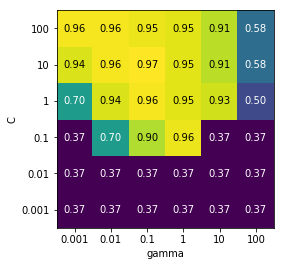

In [26]:
scores = np.array(results.mean_test_score).reshape(6, 6)

# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis")

The color encodes the cross-validation accuracy, with light colors meaning high accuracy and dark colors meaning low accuracy.
We can take away from this plot several things. 
- First, the parameters we adjusted are very important for obtaining good performance. 
- Both parameters (C and gamma) matter a lot, as adjusting them can change the accuracy from 40% to 96%. 
- Additionally, the ranges we picked for the parameters are ranges in which we see significant changes in the outcome. - It’s also important to note that the ranges for the parameters are large enough: the optimum values for each parameter are not on the edges of the plot.

#### Search over spaces that are not grids

- In some cases, trying all possible combinations of all parameters as GridSearchCV usually does, is not a good idea. 
- For example, SVC has a kernel parameter, and depending on which kernel is chosen, other parameters will be relevant. 

- If kernel='linear', the model is linear, and only the C parameter is used. 
- If kernel='rbf', both the C and gamma parameters are used (but not other parameters like degree). 
- In this case, searching over all possible combinations of C, gamma, and kernel wouldn’t make sense: if kernel='linear', gamma is not used, and trying different values for gamma would be a waste of time. 

- To deal with these kinds of “conditional” parameters, GridSearchCV allows the param_grid to be a list of dictionaries. Each dictionary in the list is expanded into an independent grid. A possible grid search involving kernel and parameters could look like this:

In [27]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("List of grids:\n{}".format(param_grid))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


- In the first grid, the kernel parameter is always set to 'rbf' (not that the entry for kernel is a list of length one), and both the C and gamma parameters are varied. 
- In the second grid, the kernel parameter is always set to linear, and only C is varied. 

In [28]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.97


In [29]:
results = pd.DataFrame(grid_search.cv_results_)
# we display the transposed table so that it better fits on the page:
display(results.T)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.00119777,0.0010006,0.000401545,0.000794125,0.000998449,0.00179739,0.00120077,0.000400114,0.000393343,0.000600195,...,0.000405693,0.000593615,0.000600529,0.000799942,0.0006001,0,0,0,0.000599861,0.000800514
std_fit_time,0.000399498,1.52588e-06,0.000491793,0.000397086,2.17157e-06,0.000742908,0.000400498,0.000490039,0.000481852,0.000490058,...,0.000496932,0.000485015,0.00049033,0.000399972,0.00048998,0,0,0,0.000489786,0.000400262
mean_score_time,0.000599289,0.000799322,0.000601387,0.000603199,0.000599813,0.000598526,0.000399399,0.000398636,0.000402069,0.000200224,...,0.000399351,0.000391483,0.000600004,0.000599957,0,0.000999928,0.00100002,0.00100045,0.000399685,0.000199938
std_score_time,0.000489319,0.000399666,0.000491034,0.000492519,0.000489749,0.000488731,0.000798798,0.000488228,0.000492443,0.000400448,...,0.000489108,0.000479615,0.000489901,0.000489863,0,2.61174e-07,4.42201e-07,1.1019e-06,0.000489512,0.000399876
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1,0.956522,0.869565,0.521739,0.347826,0.869565,1,1,1,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,0.956522,0.956522,0.913043,0.521739,0.347826,0.869565,0.913043,0.956522,1,0.956522


Similarly to cross_val_score, GridSearchCV uses stratified k-fold cross-validation by default for classification, and k-fold cross-validation for regression.

**Nested Cross Validation**

**Parallelizing cross-validation and Grid search**